## Imports

In [15]:
from autograd import Value, populate_dataframe, build_causal_graph, draw_computational_graph
import numpy as np
import pandas as pd
from shapflow.flow import GraphExplainer
import os

## Equation

In [16]:
def sanity_check_fn(x1, x2):
    Value.reset()

    x1 = Value(x1, label='x1')
    x2 = Value(x2, label='x2')

    y = x1 + x2 + x1*x2
    y.label = 'y'

    return y

## Generate and Prepare Data

In [17]:
N = 100
x1 = np.random.randn(2)
x2 = np.random.randn(2)

# Set specific values for foreground and background samples
x1[0] = 0  # background sample
x2[0] = 2
x1[1] = 1  # foreground sample
x2[1] = 1

# Create DataFrame
X = pd.DataFrame.from_dict({'x1': x1, 'x2': x2})

# Define and apply function
f = lambda x: x[:,0] + x[:,1] + x[:,0]*x[:,1]
f_d = pd.DataFrame.from_dict({'f': list(f(np.array(X)))})
pd.concat((X, f_d), axis=1)

# Populate DataFrame with computed values
populate_dataframe(X, sanity_check_fn)
print("Generated DataFrame:")
print(X)

['x1', 'x2']
Generated DataFrame:
    x1   x2  (x2*x1)  (x1+x2)    y
0  0.0  2.0      0.0      2.0  2.0
1  1.0  1.0      1.0      2.0  3.0


## Generate Computational Graph

Computational Graph Generated


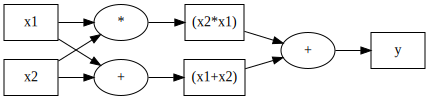

In [18]:
Value.reset()
y = sanity_check_fn(0.1, 0.1)
target_name = 'y'

computational_graph = draw_computational_graph(y, disable_data_field=True, disable_grad_field=True)
print("Computational Graph Generated")
computational_graph

## Build Causal Graph

[(['x2', 'x1'], ['(x2*x1)'], [<function op_to_function.<locals>.mul at 0x1754a6160>]), (['x2', 'x1'], ['(x1+x2)'], [<function op_to_function.<locals>.add at 0x1754a6de0>]), (['(x1+x2)', '(x2*x1)'], ['y'], [<function op_to_function.<locals>.add at 0x1754a5a80>])]


0it [00:00, ?it/s]

Causal Graph Generated


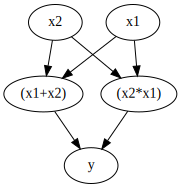

In [19]:
causal_graph = build_causal_graph(y, X.drop(columns=['y']), target_name)
print("Causal Graph Generated")
causal_graph.draw(rankdir='TB')

## Shapley Flow Analysis

bruteforce sampling: 100%|██████████| 10000/10000 [00:00<00:00, 11862.34it/s]


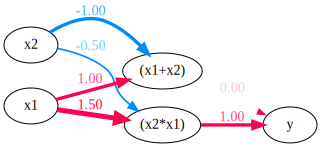

In [20]:
# Set up parameters
nruns = 10000  # number of monte carlo samples
sample_idx = 0
bg = X[:1]  # background sample
fg = X[1:2]  # foreground sample to explain

# Compute Shapley flows
cf_flow = GraphExplainer(causal_graph, bg, nruns=nruns).shap_values(fg, rankdir='LR')
cf_flow.fold_noise = True
shapflow_graph = cf_flow.draw(sample_idx, show_fg_val=False)

## Save Results

In [21]:
dir_name = 'sanity_check'
save_dir = f'results/{dir_name}'
os.makedirs(save_dir, exist_ok=True)

computational_graph.render(os.path.join(save_dir, 'computational_graph'), format='png')
causal_graph.to_graphviz(rankdir='LR').draw(
    path=os.path.join(save_dir, 'causal_graph.png'),
    format='png',
    prog='dot'
)
shapflow_graph.draw(
    path=os.path.join(save_dir, 'shapflow_graph.png'),
    format='png',
    prog='dot'
)

print("All graphs have been saved to:", save_dir)

All graphs have been saved to: results/sanity_check
